# Digital homodyne detection

In [1]:
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
from tqdm import tqdm
from qutip import *
from scipy.interpolate import interp1d
from scipy.special import factorial, eval_hermite, comb
from scipy.integrate import quad
from joblib import Parallel, delayed

## Define basic operators

In [2]:
N=15

idc = qeye(N)
ida = qeye(2)

a  = tensor(destroy(N), ida)
sm = tensor(idc, destroy(2)) # note that this is not qutip's sigmam() definition

sx = tensor(idc, sigmax())
sy = tensor(idc, sigmay())
sz = tensor(idc, sigmaz())

proj0 = tensor(idc, basis(2,0).proj())
proj1 = tensor(idc, basis(2,1).proj())

N_cav = tensor(num(N), ida)

## Define unitaries

In [3]:
def rotateX(theta):
    op = (-1j) * (theta/2) * sx
    return op.expm()

def rotateY(theta):
    op = (-1j) * (theta/2) * sy
    return op.expm()

def rotateXY(theta,rotangl):
    op = (-1j) * (theta/2) * (np.cos(rotangl)* sx + np.sin(rotangl)* sy)
    return op.expm()

def U_gint(gint):
    H = (-1j) * gint * (a.dag() * sm + a * sm.dag())
    return H.expm()

## Parameters and initial state

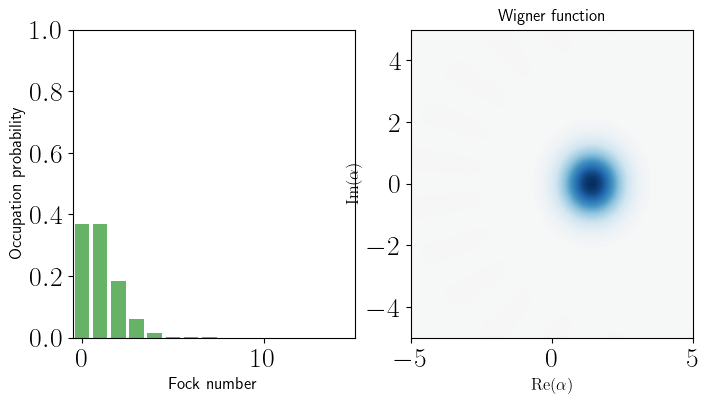

In [4]:
# number of qubit measurements per trajectory
Nmeas = 200

# number of trajectories
Ntrajs = 1000


delta_t = 0.3 #µs

# effective interaction strength
theta = 0.1*np.pi/2

gamma = theta**2/delta_t

# initialize state

alpha=1
initial_cavity = coherent(N, alpha) 

psi0 = tensor(initial_cavity, basis(2,0))
n_init = expect(N_cav, psi0)
plot_wigner_fock_distribution(initial_cavity, alpha_max=5);

## Mode matching function

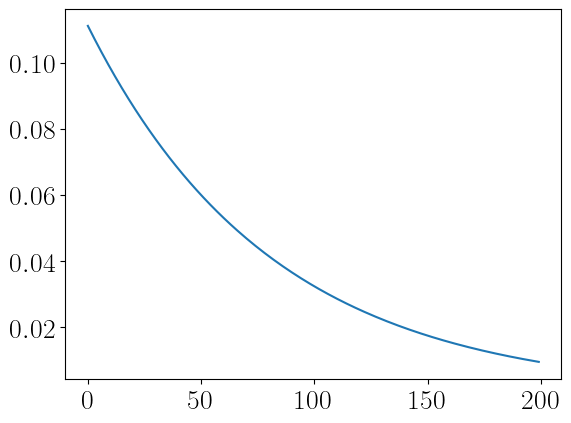

In [5]:
# weight measurement results with exponential filter
nsteps = np.arange(Nmeas)

nsteps = np.linspace(0,Nmeas-1,Nmeas)
weights=(theta/np.sqrt(2))*np.exp(-nsteps*(theta**2/2))
plt.plot(weights)

# Realistic readout with cavity decay
with rate $\kappa$. Interaction time is $\Delta t$ = ``delta_t`` and total time is ``dt_total`` set above.

In [6]:
# histogram settings
k = 5 # histogram bin limit
Nbins = 55

In [84]:
kappa = 0
dt_total = 1.2


qbrotmat = rotateXY(np.pi/2,0) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state

prng = np.random.RandomState(12377890)

U_int = U_gint(theta)

def get_measurements(kappa):
    
    L = liouvillian(0*a, [np.sqrt(kappa*dt_total)*a])
    op = L.expm()

    gamma = theta**2/delta_t
    gamma_effective = gamma/factor 

    ### Homodyne efficiency
    eta = gamma_effective/(gamma_effective + kappa) 

    weights=(theta/np.sqrt(2))*np.exp(-nsteps*(theta**2/2 + kappa*dt_total/2) )/eta

    
    measurements = []
    for j in tqdm(range(Ntrajs)):
            xrnd = prng.rand(Nmeas)
        
            results = []
            psi = ket2dm(psi0)
    
            
            for i in range(Nmeas):
                U = qbrotmat * U_int 
                psi = U * psi * U.dag()
                prob = expect(proj0,psi)
                           
                # deterministic loss 
                vec_rho = operator_to_vector(psi)          
                psi = vector_to_operator(op*vec_rho)
    
                if prob > xrnd[i]:
                    # measured g
                    results.append(-1)
                    psi = (proj0 * psi * proj0).unit()
                else:
                    results.append(1)
                    # measured e
                    psi = (proj1 * psi * proj1 ).unit()
                    # go back to g
                    psi = qbfeedback * psi* qbfeedback.dag()
         
            measurement = np.sum(results*weights)
            measurements.append(measurement)

    return measurements

In [85]:
%%time
kappa0 = 0
kappa1 = 0.002
kappa2 = 0.005
kappa3 = 0.01
kappa4 = 0.02
kappa5 = 0.05
kappa6 = 0.1
kappa7=0.2
kappa8 = 0.4
kappa9 = 0.8


measurement0 = get_measurements(kappa0)
measurement1 = get_measurements(kappa1)
measurement2 = get_measurements(kappa2)
measurement3 = get_measurements(kappa3)
measurement4 = get_measurements(kappa4)
measurement5 = get_measurements(kappa5)
measurement6 = get_measurements(kappa6)
measurement7 = get_measurements(kappa7)
measurement8 = get_measurements(kappa8)
measurement9 = get_measurements(kappa9)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:14<00:00,  3.93it/s]

CPU times: user 1h 18min 27s, sys: 33min 26s, total: 1h 51min 53s
Wall time: 55min


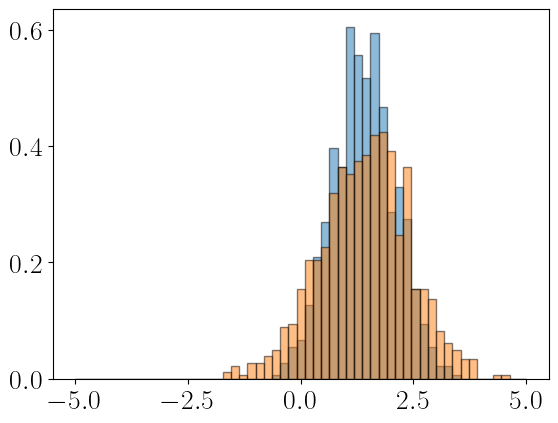

In [91]:
plt.hist(measurement0,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5)
#plt.hist(measurement1,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5)
#plt.hist(measurement2,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5)
#plt.hist(measurement3,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5);
plt.hist(measurement4,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5);
#plt.hist(measurement5,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5);
#plt.hist(measurement6,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5);
#plt.hist(measurement9,Nbins,[-5,5], density=True, edgecolor='k', alpha=0.5);

x = np.linspace(-k,k)
#plt.plot(x+2*np.sqrt(2), np.abs(np.exp(-x**2/2)*(1/np.pi)**(1/4))**2)

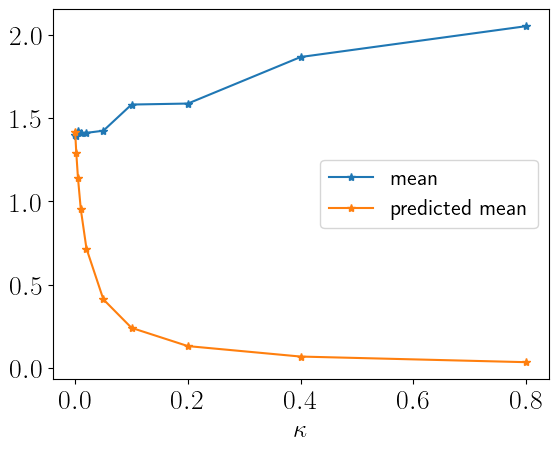

In [88]:
meas_list = [measurement0, measurement1, measurement2, measurement3, measurement4, measurement5, measurement6, measurement7, measurement8, measurement9]
kappa_list = [kappa0, kappa1, kappa2,kappa3, kappa4, kappa5, kappa6, kappa7, kappa8, kappa9]
mean_list = [np.mean(meas) for meas in meas_list]


factor = dt_total/delta_t
gamma_effective = gamma/factor


eta_list = [gamma_effective/(gamma_effective + kappa) for kappa in kappa_list]

plt.plot(kappa_list, mean_list,'*-',label='mean')
plt.xlabel('$\kappa$')

#mean_original = np.mean(measurement0)
mean_original = 1*np.sqrt(2)
mean_prediction_list = [mean_original*eta for eta in eta_list]

plt.plot(kappa_list, mean_prediction_list,'*-', label='predicted mean')
plt.legend();

### Test vacuum admixture in state

In [69]:
states_list = [eta*coherent_dm(N,1) + (1-eta)*fock_dm(N,0) for eta in eta_list]
 

In [70]:
def get_measurements(Ntrajs, theta, psi0):
    U_int = U_gint(theta)
    
    ### simulate tomography ###
    
    qbrotmat = rotateXY(np.pi/2,0) # qb rotation applied prior to qb measurement, defines measured homodyne quadrature
    
    qbfeedback = rotateX(np.pi) # this pulse will reset the qubit if found in the excited state
    measurements = []

    for j in range(Ntrajs):
            xrnd = prng.rand(Nmeas)
        
            results = []
            psi =tensor(psi0, fock_dm(2,0))
    

            for i in range(Nmeas):
                U = qbrotmat * U_int 
                psi = U * psi * U.dag()
                prob = expect(proj0,psi)
    
                if prob > xrnd[i]:
                    # measured g
                    results.append(-1)
                    psi = (proj0 * psi * proj0).unit()
                else:
                    results.append(1)
                    # measured e
                    psi = (proj1 * psi * proj1 ).unit()
                    # go back to g
                    psi = qbfeedback * psi* qbfeedback.dag()
         
            measurement = np.sum(results*weights)
            measurements.append(measurement)

    return measurements

In [71]:
measurements_list = [get_measurements(Ntrajs, theta, state) for state in states_list]
mean_list3 = [np.mean(meas) for meas in measurements_list]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:28<00:00,  4.80it/s]


Text(0.5, 0, '$\\eta$')

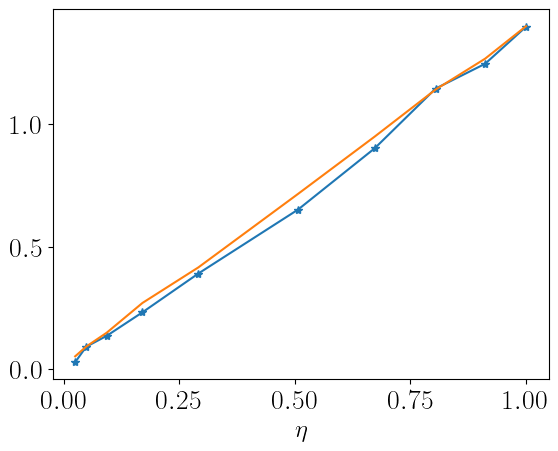

In [72]:
plt.plot(eta_list, mean_list3,'*-',label='mean')
plt.plot(eta_list, mean_list)
plt.xlabel('$\eta$')